In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from typing import Union

In [8]:
IMAGE_PATH = './Brodatz_examples/'

In [9]:
def getPatches(image: np.ndarray, locations: list, patch_size=20) -> list:
    res = []
    for loc in locations:
        res.append(image[loc[0] : loc[0] + patch_size, loc[1] : loc[1] + patch_size])
    return res


In [10]:
def getFeatureVector(texel: np.ndarray, stats: list):

    glcm = graycomatrix(
        texel, distances=[5], angles=[0], levels=256, symmetric=True, normed=True
    )
    vect = []

    for stat in stats:
        vect.append(graycoprops(glcm, prop=stat)[0, 0])
    return vect

In [11]:
def getTrainingData(texels: list, stats: list[str]) -> list:
    vectors = []
    for tx in texels:
        vectors.append(getFeatureVector(tx, stats))
    return vectors


In [12]:
def getTexelData(
    image_path: str,
    stats=["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"],
):
    textura = plt.imread(IMAGE_PATH + image_path)
    textura = cv2.cvtColor(textura, cv2.COLOR_RGB2GRAY)

    ubicacion_texels = [
        (0, 0),
        (200, 150),
        (250, 350),
        (100, 100),
        (50, 400),
        (400, 100),
        (300, 120),
        (123, 342),
        (421, 111),
        (23, 33),
        (265, 31),
        (78, 473),
        (300, 300),
        (400, 212),
    ]
    texels = getPatches(textura, ubicacion_texels, 40)
    return getTrainingData(texels, stats)

In [13]:
def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield(x,y,image[y:y+windowSize[1],x:x+windowSize[0]])

In [14]:
images = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
tr_data = []
tr_lbls = []
k = 0
for img in images:
  tr_data += getTexelData(img)
  tr_lbls += [k for _ in range(14)]
  k+= 1

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tr_data,tr_lbls)

KNeighborsClassifier()

In [16]:
gnb = GaussianNB()
gnb.fit(tr_data,tr_lbls)

GaussianNB()

In [17]:
svm = SVC()
svm.fit(tr_data,tr_lbls)

SVC()

In [18]:
def evaluarClasificador(
    clasificador,
    imagen,
    windowStep,
    windowSize,
    stats=["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"],
):
    colores = [
        [57, 17, 181],
        [17, 148, 145],
        [149, 206, 195],
        [244, 116, 168],
        [58, 202, 75],
        [210, 29, 24],
        [110, 20, 248],
        [246, 190, 17],
    ]
    res = np.zeros(shape=imagen.shape)
    res = np.dstack([res, res, res])
    for (x, y, window) in sliding_window(imagen, windowStep, windowSize):

        vector = getFeatureVector(window, stats)

        color_prediction = colores[int(clasificador.predict([vector]))]
        for iy in range(y, y + 10):
            for ix in range(x, x + 10):
                if ix < res.shape[1] and iy < res.shape[0]:
                    res[iy, ix] = color_prediction

    return res

7


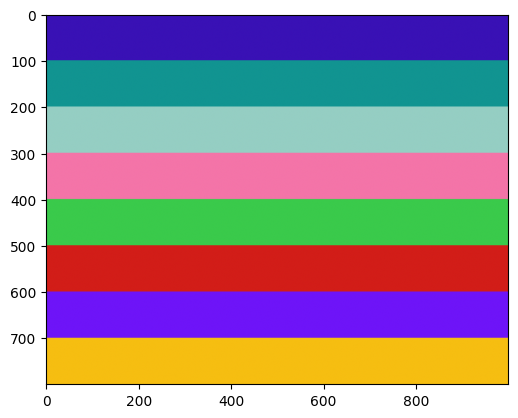

In [19]:
colores = [[57, 17, 181], [17, 148, 145], [149, 206, 195], [244, 116, 168], [58, 202, 75], [210, 29, 24], [110, 20, 248], [246, 190, 17]]
imagen = np.zeros(shape=(800,1000))
imagen = np.dstack([imagen,imagen,imagen])
print(757//100)
for ix in range(imagen.shape[0]):
  for iy in range(imagen.shape[1]):
    imagen[ix,iy] = colores[ix//100]
    
plt.imshow(imagen/255)

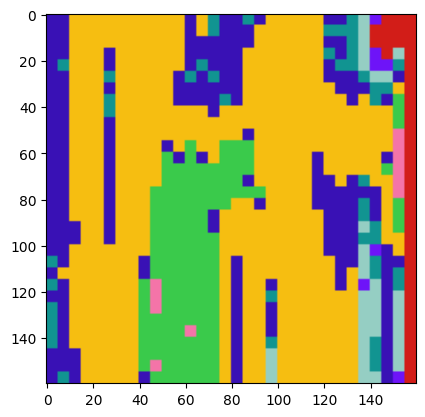

In [20]:
img1 = plt.imread('./Brodatz_examples/D51.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
test1 = evaluarClasificador(knn,img1[480:,480:],5,(40,40))
plt.imshow(test1.astype(int))

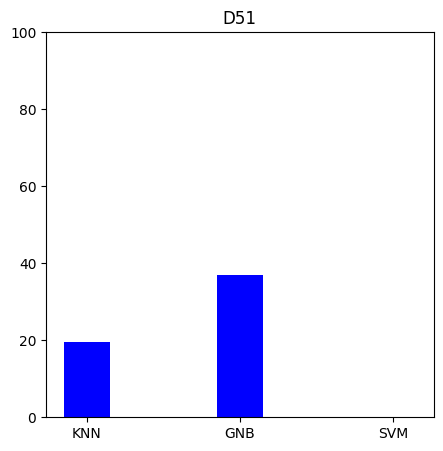

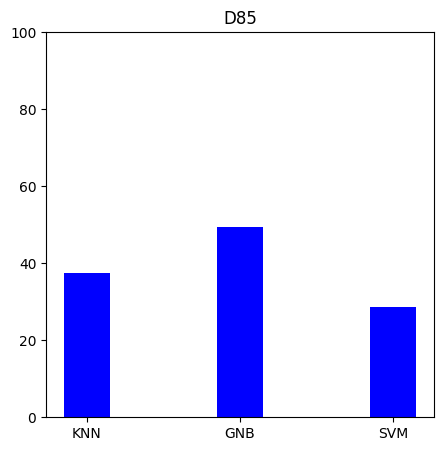

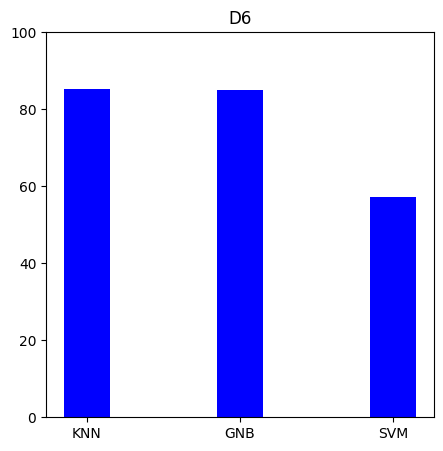

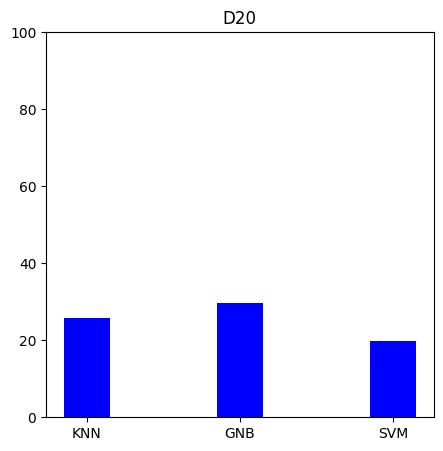

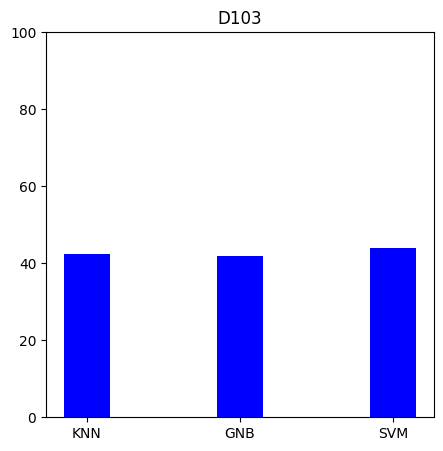

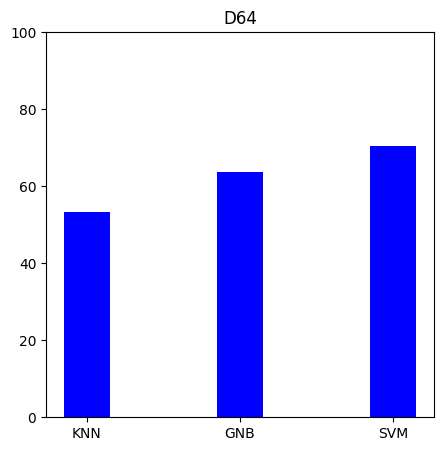

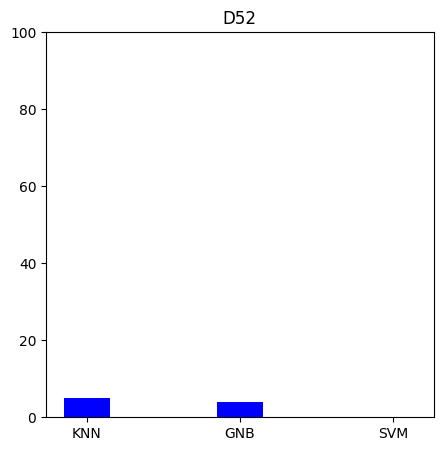

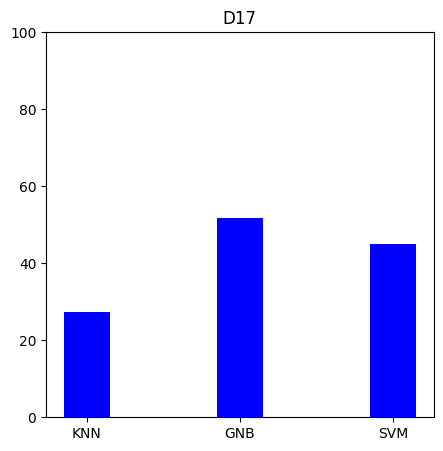

In [21]:
clasificadores = [knn, gnb, svm]
lbl = ['KNN','GNB','SVM']
images = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
colores = [[57, 17, 181], [17, 148, 145], [149, 206, 195], [244, 116, 168], [58, 202, 75], [210, 29, 24], [110, 20, 248], [246, 190, 17]]

for key_img,img_path in enumerate(images):
  img = plt.imread('./Brodatz_examples/'+img_path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  precision = [0,0,0]
  for key,clasificador in enumerate(clasificadores):
    test = evaluarClasificador(clasificador,img[480:,480:],5,(40,40))
    test = test.astype(int)
    for ix in range(test.shape[0]):
      for iy in range(test.shape[1]):
        color = test[ix,iy]
        precision[key] += 1 if (color == colores[key_img]).all() else 0
  accuracy = np.array(precision) / (160*160) * 100
  name = img_path.split('.')[0] + '_resultados.png'  
  fig = plt.figure(figsize=(5,5))
  plt.bar(lbl,accuracy,color='blue',width=0.3)
  plt.ylim(0,100)
  plt.title(img_path.split('.')[0])
  plt.savefig('./resultados/'+name)

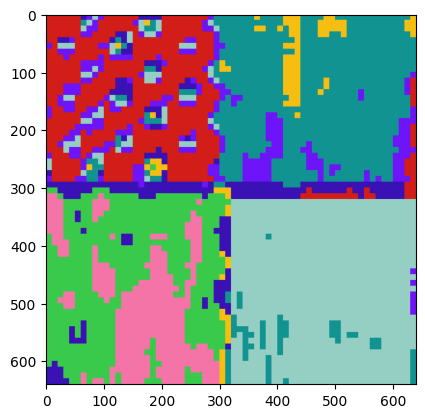

In [22]:
images = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
compuesta = plt.imread('./imagenes_combinadas/textura_compuesta3.bmp')
compuesta = cv2.cvtColor(compuesta, cv2.COLOR_RGB2GRAY)

res = evaluarClasificador(gnb,compuesta,  10, (40,40))
plt.imshow(res.astype(int))
plt.imsave('./resultados/compuesta3.png',res.astype(np.uint8))